# 🚢 **Titanic survival prediction**
___

## 📃**The Problem** ##
This is the titanic problem. Let's see if Mary would have survived the Titanic, if she were aboard.

<p class="alert alert-info alert-block">The code cell below imports the required Python packages and performed all settings for the project</p>

⚙ **Setup**

In [1]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import sklearn
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression

import warnings


parent_dir = os.path.abspath("..")
if parent_dir not in sys.path:
    sys.path.append(parent_dir)
    
from _custom_func import extract_data, load_data
from titanic_module import age_map


sns.set_style("darkgrid")
pd.set_option("display.max_columns", None)
sklearn.set_config(display="diagram")


warnings.filterwarnings("ignore")

print("\n💯 😊 \033[034mSetup successfully loaded to memory.\033[om 💹")


💯 😊 Setup successfully loaded to memory.m 💹


## 📝 **Get the data**

The data is the famouus titanic dataset, downloaded as a zim file from 👉 [here](https://kagggke.com/). The function `extract_data` is used to extract the data into a `csv` saved in the `./data` directory.

In [2]:
df = load_data("./data/Titanic-Dataset.csv")
df.head()


Data loaded successfully . . .


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## 🔎 **Observe the data**

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [4]:
df_num = df.select_dtypes(include=np.number)
df_num.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


The median age is $28$, meaning that half of the total passengers have ages that are less than or equal to $28$. The maximum age is $80$, meaning that there are children, youtg and adults in the ship. The mean age is $29$, that is most passengers are youths. The age attribute was not copletely recorded.

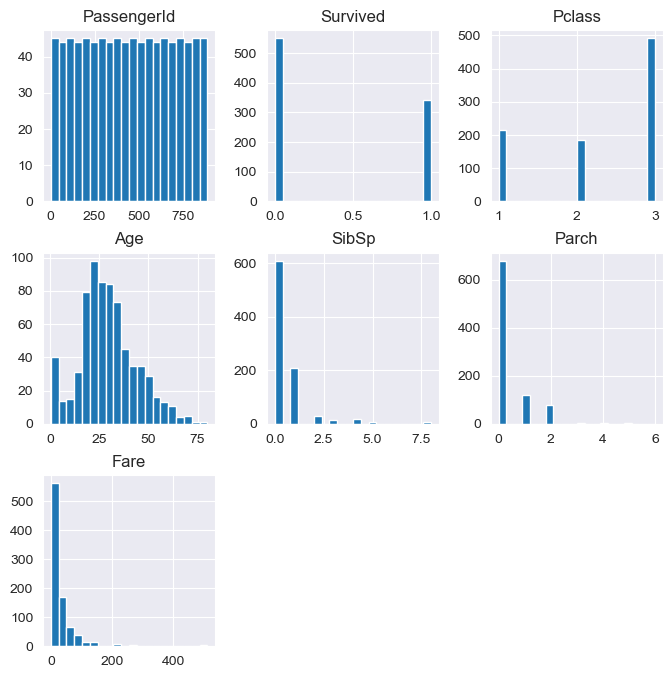

In [5]:
ax = df_num.hist(bins=20, figsize=(8,8))
plt.show()

By inspectinng the data, it is observed that $11$ features are present per instance. There are $891$ instances. Some features have missing values. From the histogram, it is observed that the attributes have different scales. Only the age data is close to a normal distribution. To analyze the data, the data needs to be clean. For exploratory data analysis, the missing numerical attributes will be replaced with the median (in the case of `Age`), while the missing categorical attributes will be replaced with the most frequent (in the case of `Cabin` and `Embarked`). The Simple Imputer from [Scikit Learn](https://scikit-learn.org) will be used to achieve this.

There are no normalization problems as each instance repreents a passenger, and each column represents a feature.

## 🧹 **Data Cleaning**

In [6]:
df_eda = df.copy()
clean_category = Pipeline(verbose=True, steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
])

clean_numeric = Pipeline(verbose=True, steps=[
    ("impute", SimpleImputer(strategy="median")),
])


df_eda[["Cabin"]] = clean_category.fit_transform(df_eda[["Cabin"]])
df_eda[["Age"]] = clean_numeric.fit_transform(df_eda[["Age"]])
df_eda[["Embarked"]] = clean_category.fit_transform(df_eda[["Embarked"]])

[Pipeline] ........... (step 1 of 1) Processing imputer, total=   0.0s
[Pipeline] ............ (step 1 of 1) Processing impute, total=   0.0s
[Pipeline] ........... (step 1 of 1) Processing imputer, total=   0.0s


In [7]:
df_eda.isna().any()

PassengerId    False
Survived       False
Pclass         False
Name           False
Sex            False
Age            False
SibSp          False
Parch          False
Ticket         False
Fare           False
Cabin          False
Embarked       False
dtype: bool

All the missing features have been filled. Done!

## 🔍 **Exploratory Data Analysis**

### 📊 Gender distribution

In [8]:
sex_recorded = df_eda.Sex.unique()
total_male = (df_eda.Sex == "male").sum()
total_female = (df_eda.Sex == "female").sum()
total_male_surv = (df_eda[df_eda.Survived == 1].Sex == "male").sum()
total_female_surv = (df_eda[df_eda.Survived == 1].Sex == "female").sum()
prop_male_female_surv = np.array([
    total_male_surv / total_male,
    total_female_surv / total_female
])
prop_in_all_surv = np.array([
    total_male_surv / len(df_eda),
    total_female_surv / len(df_eda)
])

summary_sex = {
    "Sex": sex_recorded,
    "total": np.array([total_male, total_female]),
    "total_survived": np.array([total_male_surv, total_female_surv]),
    "% survived per gender": (prop_male_female_surv*100).round(2),
    "% survived in all passenger": (prop_in_all_surv*100).round(2)
}

sex_distribution = pd.DataFrame(summary_sex, index=["Male", "Female"]).drop("Sex", axis=1)
sex_distribution

,total,total_survived,% survived per gender,% survived in all passenger
Male,577,109,18.89,12.23
Female,314,233,74.20,26.15


array([<Axes: ylabel='total_survived'>,
       <Axes: ylabel='% survived per gender'>,
       <Axes: ylabel='% survived in all passenger'>], dtype=object)

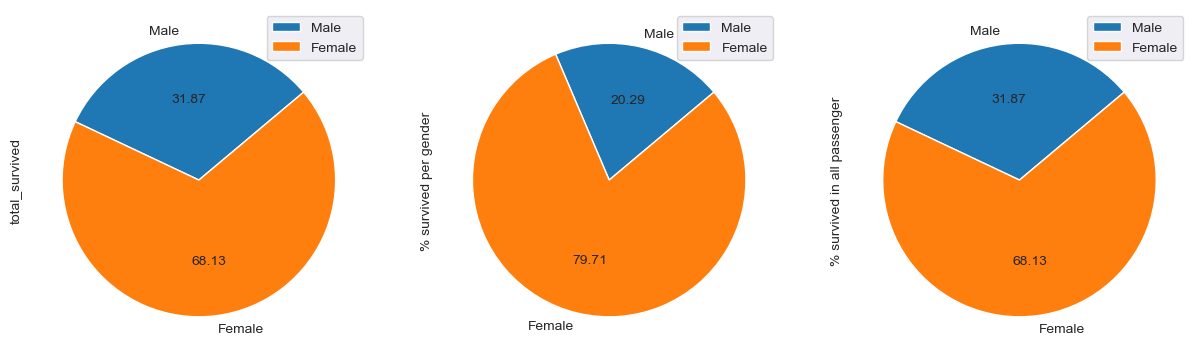

In [9]:
sex_distribution.iloc[:, 1:].plot.pie(subplots=True, startangle=40, autopct="%.2f", label=["Male", "Female"], figsize=(15, 5))

Generally, more females survived the havok. Out of 314 female passengers, 233 survived, while 109 survived from the much more 577 male passengers.

### 📊 **Age Ditribution**

The values of the age attribute are grouped as dipicted in the table below.
| Range        | Age Group   |
| -------------|-------------|
| 0 - 19       | chidren     |
| 10 - 17      | adolescent  |
| 18 - 24      | youth       |
| 25 - 34      | young adult |
| 35 - 49      | adult       |
| 50 - 64      | older adult |
| 65 and above |  Old Age    | 

Text(0, 0.5, '')

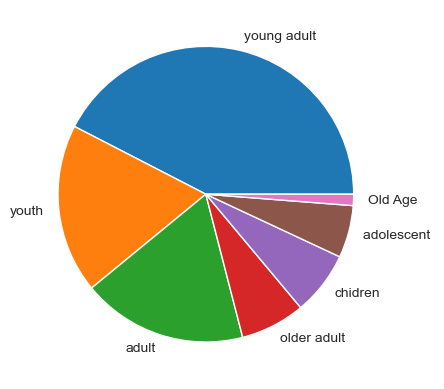

In [14]:
df_eda["AgeGroup"] = df_eda.Age.map(age_map)
ax = df_eda.AgeGroup.value_counts().plot.pie()
ax.yaxis.set_label_text("")

Majority of the passengers were young adults.

Text(0.5, 1.0, 'Distribution of Age Group\nwith Survival')

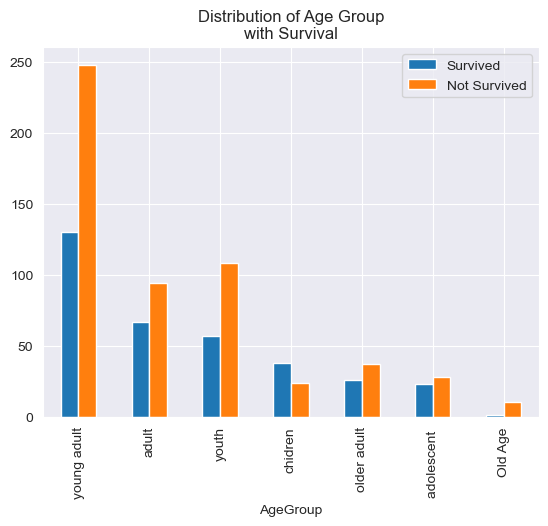

In [33]:
ax = (pd.concat([df_eda[df_eda.Survived == 1].AgeGroup.value_counts(),
           df_eda[df_eda.Survived == 0].AgeGroup.value_counts()], axis=1)).plot.bar()
ax.legend(["Survived", "Not Survived"])
ax.set_title("Distribution of Age Group\nwith Survival")

Most of the passengers that survived fall in the age group young adult, having ages between 25 to 34.

**Variation between age and sex**

It is also important to consider how age and sex affect the probability that a passenger survived.

Now, to check if the attributes correlate with one-another. This is only applicable to numerical attributes.

**Correllations**

To see how each variable correlates with the other.

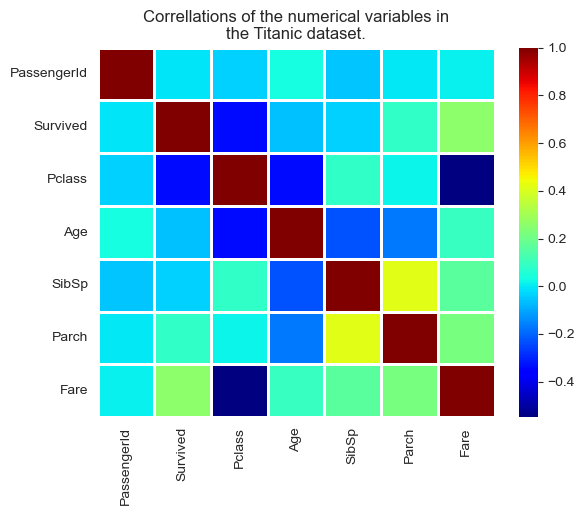

In [39]:
correllation_matrix = df_eda.select_dtypes(include=[np.number]).corr()
ax = sns.heatmap(correllation_matrix, linewidths=1, cmap="jet")
cor_matrix_titile = ax.set_title("Correllations of the numerical variables in\nthe Titanic dataset.")

Some information are immediately obvious from the correlation marix. The higher the number of siblings/spouse, the higher the number of parents/children. Hene, couples tends to board the ship alongside their children.

Also, The fare tends to correlate positively with Survival. Also, the attribute Pclass tends to correlate negatively with Survival. This means that passengers in the high class (Pclass 1) had greater a chance to survive.

Generating aother feature from the cabin attribute, this is dock number. This is the firt letter (alphabet) in the ccabin names.

Text(0, 0.5, 'Count')

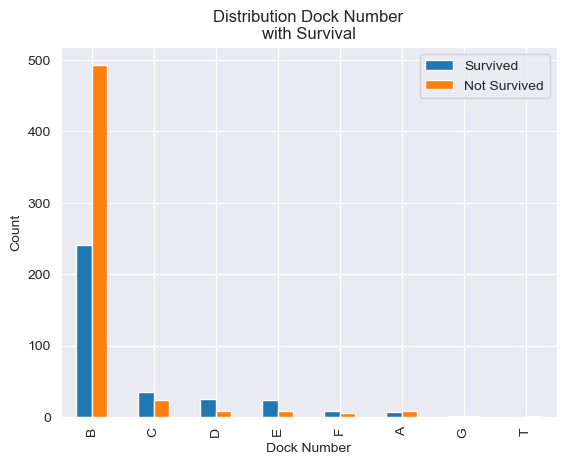

In [56]:
ax = (pd.concat([df_eda[df_eda.Survived == 1].DockNumber.value_counts(),
           df_eda[df_eda.Survived == 0].DockNumber.value_counts()], axis=1)).plot.bar()
ax.legend(["Survived", "Not Survived"])
ax.set_title("Distribution Dock Number\nwith Survival")
ax.xaxis.set_label_text("Dock Number")
ax.yaxis.set_label_text("Count")

Majority of the passenger falls in the dock number "B", assuming the first alphaet of the cabin name represents dock number. More than halp of the pssengers from other docks except dock B survived.

## 🛠 Prepare the data for machine learning

To prepare the data for machine lerning algorithm, all the transformation made tho the data frame has to be done by scikit learn transformers in a single pipeline. This will enable us to transform new data.

Some attributes do not affect our ML algorithm, as an example, PassengerId, Ticket. Any feature whose values are unique does not affect ML alggorithms.

We use another copy of the data.

Also, the data has to be splitted into train set and test set.

In [58]:
df_titanic = df.copy()

### 🧹**Data Cleaning**


### ✂ Split the data

Split the data into train set and test set, and separae features from labels.

In [60]:
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
for train_index, test_index in splitter.split(df_titanic, df_titanic["Sex"]):
    train_set = df_titanic.loc[train_index]
    test_set = df_titanic.loc[test_index]

☑ **Verify that the split was performed as expected**

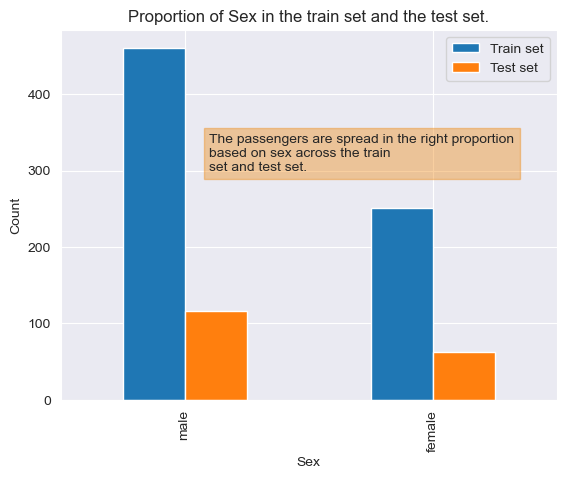

In [61]:
ax = pd.concat([
        pd.DataFrame(train_set.Sex.value_counts()),
        pd.DataFrame(test_set.Sex.value_counts())], axis=1).plot.bar()
ax.legend(["Train set", "Test set"])
ax.yaxis.set_label_text("Count")
ax.set_title("Proportion of Sex in the train set and the test set.")
ax.text(0.1, 300, "The passengers are spread in the right proportion\nbased on sex across the train\nset and test set.",
       bbox={"color": "#ef8912", "alpha": 0.4});

#### 🗄 Separate features from labels

In [108]:
X_train, y_train = train_set.drop(["Survived"], axis=1), train_set["Survived"]
X_test, y_test = test_set.drop(["Survived"], axis=1), test_set["Survived"]

### 💽 Data Preprocessing

In [109]:


numerical_pipeline = Pipeline(verbose=True, steps=[
    ("impute", SimpleImputer(strategy="median")),
    ("normalize", StandardScaler())
])

categorical_pipeline = Pipeline(verbose=True, steps=[
    ("impute", SimpleImputer(strategy="most_frequent")),
    ("encode", OneHotEncoder(handle_unknown="ignore"))
])

preprocessing = ColumnTransformer([
    ("num_pipeline", numerical_cols, make_column_selector(dtype_include=np.number)),
    ("cat_pipeline", categorical_cols, make_column_selector(dtype_include=object))
])

In [110]:
preprocessing

ColumnTransformer(transformers=[('num_pipeline',
                                 Pipeline(steps=[('impute',
                                                  SimpleImputer(strategy='median')),
                                                 ('normalize',
                                                  StandardScaler())],
                                          verbose=True),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000002BE2268DC10>),
                                ('cat_pipeline',
                                 Pipeline(steps=[('impute',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encode',
                                                  OneHotEncoder(handle_unknown='ignore'))],
                                          verbose=True),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000002BE233E1D50>)])

In [111]:
X = preprocessing.fit_transform(X_train)

[Pipeline] ............ (step 1 of 2) Processing impute, total=   0.0s
[Pipeline] ......... (step 2 of 2) Processing normalize, total=   0.0s
[Pipeline] ............ (step 1 of 2) Processing impute, total=   0.0s
[Pipeline] ............ (step 2 of 2) Processing encode, total=   0.0s


In [112]:
preprocessing.feature_names_in_

array(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked',
       'Cabin_Dock'], dtype=object)

In [113]:
preprocessing.get_feature_names_out()

array(['num_pipeline__Pclass', 'num_pipeline__Age', 'num_pipeline__SibSp',
       'num_pipeline__Parch', 'num_pipeline__Fare',
       'num_pipeline__Cabin_Dock', 'cat_pipeline__Sex_female',
       'cat_pipeline__Sex_male', 'cat_pipeline__Embarked_C',
       'cat_pipeline__Embarked_Q', 'cat_pipeline__Embarked_S'],
      dtype=object)

In [114]:
pd.DataFrame(X).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 712 entries, 0 to 711
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       712 non-null    float64
 1   1       712 non-null    float64
 2   2       712 non-null    float64
 3   3       712 non-null    float64
 4   4       712 non-null    float64
 5   5       712 non-null    float64
 6   6       712 non-null    float64
 7   7       712 non-null    float64
 8   8       712 non-null    float64
 9   9       712 non-null    float64
 10  10      712 non-null    float64
dtypes: float64(11)
memory usage: 61.3 KB


## 👩‍🏫 Select and train a model
At this point, some promising model are tested.
- Logistic Regression

In [116]:
logistic_model = LogisticRegression()
logistic_model.fit(X, y_train)

LogisticRegression()